![](pokemon.png)

# Attrapez les tous : Analyses des déterminants de la victoire dans les batailles de Pokémon

#### Travail présenté dans le cadre du cours GPL-3008 : Gestion et analyse de bases de données en sciences sociales 

### Par Nicolas Corneau-Tremblay

#### (Exemple de travail long pour le cours)


### 0. Préambule

Ce travail porte sur les combats de Pokémon. Dans celui-ci, nous tentons d'explorer la dynamique de ces combats et d'entraîner un modèle prédictif permettant de déterminer le vainqueur lors d'un affrontement entre deux Pokémon.

Le travail est structuré de la façon suivante : la première partie présente la construction d'une base de données SQLite permettant de mettre les différentes tables disponibles en commun; La seconde partie présente le partitionnement et le traitement des données; la troisième partie contient une analyse exploratoire des combats à l'aide de la méthode des k-moyennes; la quatrième partie présente la construction d'un modèle prédictif de type forêt aléatoire de même que l'évaluation de sa performance; une conclusion termine le tout.

In [1]:
# Modules utilisées
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sqlite3

# Fonctions utilisées provenant de certains modules
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import NotFittedError
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

# Définition de la localisation de travail
os.chdir("/Users/nct/Dropbox (CEDIA)/ULaval/GPL-3008/Travail long - Perso")

### 1. Importation des données

Cette section présente la construction d'une base de données SQLite permettant de mettre en commun les différentes tables que nous comptons utiliser dans le cadre de ce travail. Ces tables sont tirées de la base de données *Pokémon -  Weedle's Cave* qui a été téléchargée sur le site [Kaggle](https://www.kaggle.com/). 

Nous vérifions d'abord que les données sont bien disponibles avant d'effectuer la construction de notre base de données.

In [2]:
os.listdir(path = "pokemon-challenge")

['combats.csv', 'pokemon.csv', 'tests.csv']

Nous créons ensuite une base de données SQLite se nommant `pokemon_data` contenant deux tables : `combat` et `pokemon` (le fichier `test.csv` ne sera pas utilisé pour ce travail). La table `combat` contient de l'information sur les différents combats : quels Pokémon se sont affrontés et qui en est sorti vainqueur. La table `pokemon` contient de l'information sur chacun des Pokémon, notamment leur niveau d'énergie et leur force de frappe offensive.

Les manipulations de la base de données sont effecutées à l'aide des fonctions `create_rdb` et `insert_data` définies ci-dessous.

In [3]:
def create_rdb() :
    """
    Cette fonction crée la base de données relationnelle et les tables qui la composent.
    """
    
    # Définition de la connection
    connect = sqlite3.connect("pokemon_data.db")

    #Définition du curseur
    cur = connect.cursor()

    # Création de la table combat
    cur.execute("CREATE TABLE IF NOT EXISTS combat(first_pokemon INT, second_pokemon INt, winner INT);")

    #création de la table pokemon
    cur.execute("""CREATE TABLE IF NOT EXISTS
            pokemon(id INT, name TEXT, type_1 TEXT, type_2 TEXT, hp INT, attack INT, defense INT, 
            sp_atk INT, sp_def INT, speed INT, generation INT, legendary TEXT);""")

    cur.close()
    connect.close()

In [4]:
def insert_data(csv_path = "", table_name = "", col_name = []) :
    """
    Cette fonction saisit les données issues d'un fichier .csv et les insère dans la table désignée.
    """
    connect = sqlite3.connect("pokemon_data.db")
    cur = connect.cursor()

    # Remplissage de la table
    temp = pd.read_csv(csv_path, header = None, names = col_name, skiprows = 1)
    temp.to_sql(table_name, connect, if_exists="append", index=False)

    connect.commit()

    cur.close()
    connect.close()

In [5]:
# Vérification de l'existence de la base de données et création de celle-ci si nécessaire
if "pokemon_data.db" in os.listdir():
    
    print("La base de données 'pokemon_data.db' a déjà été créée.")
    
else :
    # Création de la base de données
    create_rdb()

    # Définition des noms de colonnes pour la table combat
    noms_col_combat = ["first_pokemon", "second_pokemon", "winner"]
    
    # Insertion des données dans la table combat
    insert_data("pokemon-challenge/combats.csv", "combat", noms_col_combat)

    # Définition des noms de colonnes pour la table pokemon
    noms_col_pokemon = ["id", "name", "type_1", "type_2", "hp", "attack", "defense",
                      "sp_atk", "sp_def", "speed", "generation", "legendary"]
    
    # Insertion des données dans la table pokemon
    insert_data("pokemon-challenge/pokemon.csv", "pokemon", noms_col_pokemon)

La base de données 'pokemon_data.db' a déjà été créée.


Lorsque la base de données SQLite est créée, il est possible d'y effectuer une requête afin d'obtenir les données dont nous avons besoin. Cette requête est effectuée à l'aide de la fonction `read_sql_query` du module `Pandas`.

In [6]:
# Importation des données nécessaires à la suite des analyses
connect = sqlite3.connect("pokemon_data.db")

df = pd.read_sql_query("""SELECT combat.first_pokemon AS first_pokemon, combat.second_pokemon AS sec_pokemon,
            combat.winner AS winner,
            pok_first.type_1 AS first_type, pok_first.hp AS first_hp, pok_first.attack AS first_atk,
            pok_first.defense AS first_def, pok_first.sp_atk AS first_sp_atk, pok_first.sp_def AS first_sp_def,
            pok_first.speed AS first_speed, pok_first.legendary AS first_leg,
            pok_sec.type_1 AS sec_type, pok_sec.hp AS sec_hp, pok_sec.attack AS sec_atk,
            pok_sec.defense AS sec_def, pok_sec.sp_atk AS sec_sp_atk, pok_sec.sp_def AS sec_sp_def,
            pok_sec.speed AS sec_speed, pok_sec.legendary AS sec_leg
            FROM combat
            LEFT OUTER JOIN pokemon AS pok_first
            ON combat.first_pokemon = pok_first.id
            LEFT OUTER JOIN pokemon AS pok_sec
            ON combat.second_pokemon = pok_sec.id;""", connect)

connect.close()

Nous devons ensuite créer notre variable dépendante pour notre modèle prédictif : le vainqueur du combat. Une fois cette variable créée, les variables `'first_pokemon'`, `'sec_pokemon'` et `'winner'` ne sont plus nécessaires. 

In [7]:
df["winner_is_1"] = df["first_pokemon"] == df["winner"]
df["winner_is_1"] = df["winner_is_1"] * 1
df = df.drop(["first_pokemon", "sec_pokemon", "winner"], axis = 1)

Pour voir les premières lignes du dataframe venant d'être créé, nous utilisons la méthode `head`.

In [8]:
df.head()

,first_type,first_hp,first_atk,first_def,first_sp_atk,first_sp_def,first_speed,first_leg,sec_type,sec_hp,sec_atk,sec_def,sec_sp_atk,sec_sp_def,sec_speed,sec_leg,winner_is_1
0,Rock,50,64,50,45,50,41,0,Grass,70,70,40,60,40,60,0,0
1,Grass,91,90,72,90,129,108,1,Rock,91,129,90,72,90,108,1,0
2,Fairy,55,40,85,80,105,40,0,Psychic,75,75,75,125,95,40,0,0
3,Fire,40,40,40,70,40,20,0,Dragon,77,120,90,60,90,48,0,0
4,Rock,70,60,125,115,70,55,0,Bug,20,10,230,10,230,5,0,1


Pour la suite de notre travail, nous utilisons différentes caractéristiques pour représenter chacun des deux Pokémon au combat. Ces caractéristiques sont le type de Pokémon (`type`), le niveau d'énergie (`hp`), la force offensive (`atk`), la force défensive (`def`), l'attaque spéciale et la défensive spéciale (respectivement `sp_atk` et `sp_def`), la vitesse (`speed`) et le fait que que le Pokémon soit légendaire ou non (`leg`). Ces variables sont définies pour les deux Pokémon combattant et possèdent donc un préfixe (respectivement `first_` et `sec_`) afin d'identifier à quel Pokémon chacune variable fait référence.

### 2. Partitionnement et préparation des données

Cette section présente le partitionnement et la préparation de nos données pour la suite des analyses.

La première étape lors de la préparation des données est le partitionnement de celles-ci. Cette étape est réalisée à l'aide de la fonction `train_test_split` du module `SciKit-Learn`. Nous attribuons une proportion de 70% à notre groupe d'entraînement et donc une proportion de 30% à notre groupe test.

In [9]:
# Partitionnement des données
train, test = train_test_split(df, test_size = 0.30, random_state = 222)
print("Taille des groupes : \nGroupe d'entraînement = ", train.shape,
      "\nGroupe test = ", test.shape, sep = "")

Taille des groupes : 
Groupe d'entraînement = (35000, 17)
Groupe test = (15000, 17)


Une fois notre groupe d'entraînement créé, nous pouvons investiguer la présence de valeurs manquantes et de valeurs aberrantes dans les données qu'il contient. Cette seconde étape est réalisée à l'aide de la méthode `describe`.

In [10]:
train.describe(include = "all")

,first_type,first_hp,first_atk,first_def,first_sp_atk,first_sp_def,first_speed,first_leg,sec_type,sec_hp,sec_atk,sec_def,sec_sp_atk,sec_sp_def,sec_speed,sec_leg,winner_is_1
count,35000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000,35000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000,35000.000000
unique,18,NaN,NaN,NaN,NaN,NaN,NaN,2,18,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,Water,NaN,NaN,NaN,NaN,NaN,NaN,0,Water,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
freq,4986,NaN,NaN,NaN,NaN,NaN,NaN,32158,4920,NaN,NaN,NaN,NaN,NaN,NaN,32101,NaN
mean,NaN,68.981114,79.187971,74.280314,72.822029,72.080743,68.177714,NaN,NaN,69.113400,79.066743,74.083114,72.796143,71.997743,68.408057,NaN,0.472571
std,NaN,25.211388,32.644604,31.634607,32.670941,27.920859,29.184342,NaN,NaN,25.138107,32.421108,31.512517,32.758536,27.597523,29.021283,NaN,0.499254
min,NaN,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,NaN,NaN,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,NaN,0.000000
25%,NaN,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000,NaN,NaN,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000,NaN,0.000000
50%,NaN,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,NaN,NaN,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,NaN,0.000000
75%,NaN,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,NaN,NaN,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,NaN,1.000000


Le tableau ci-haut nous renseigne sur les variables présentes dans notre groupe d'entraînement. D'abord, comme il est possible de le constater, aucune de nos variables numériques, y compris les variables contenant des entiers (`first_leg` et `sec_leg`) et des booléens (`winner_is_1`), ne semble contenir de valeurs manquantes puisque celles-ci contiennent toutes 35 000 observations. Par ailleurs, aucune variable ne semble *a priori* contenir de valeurs aberrantes.

Notre seule variable catégorique est la variable indiquant le type de Pokémon (`'first_type_1'` et `'sec_type_1'`).

In [11]:
train["first_type"].value_counts()

Water       4986
Normal      4205
Bug         3077
Grass       2968
Psychic     2584
Fire        2255
Rock        2008
Electric    1834
Ghost       1398
Dragon      1373
Ground      1361
Dark        1360
Poison      1254
Steel       1241
Fighting    1150
Ice         1045
Fairy        732
Flying       169
Name: first_type, dtype: int64

Cette variable ne semble également pas contenir de valeur manquante ou d'erreur d'enregistrement dans ses différentes catégories.

La première étape dans la préparation de nos données est la création de variable dépendante pour notre modèle prédictif, `train_y`, séparemment des variables explicatives.

In [ ]:
# Construction de l'outcome
train_y = train["winner_is_1"].values
train = train.drop("winner_is_1", axis = 1)

L'étape suivante est la dichotomisation de nos variables catégoriques et la standardisation de nos variables numériques continues. La variable indiquant le type de Pokémon est dichotomisée à l'aide de la fonction `get_dummies` du module `Pandas`. Les variables binaires créées sont ensuite jointes à un  un dataframe comprenant les autres variables dichotomiques (`first_leg`, `sec_leg` et `winner_is_1`). Toutes ces étapes sont réalisées à l'aide de notre fonction `tran_dummy`.

In [12]:
def tran_dummy(df, var_dummy, var_untouched) :
    """
    Cette fonction effectue la gestion des variables catégoriques d'un dataframe.
    """
    
    # Obtention des variables dichotomiques
    df_temp = pd.get_dummies(df[var_dummy])
    
    # Réunion des variables dichotomisées et des autres variables
    df_temp = pd.concat([df_temp, df[var_untouched]],
                       axis = 1, join_axes = [df_temp.index])
    df_temp.reset_index(drop = True, inplace = True)
    
    return df_temp

In [13]:
# Dichotomisation des variables catégoriques
train_cat = tran_dummy(train, ["first_type", "sec_type"], ["first_leg", "sec_leg"])

Les variables numériques continues sont ensuite standardisées à l'aide des méthodes `fit_transform` et `transform` de la classe `StandardScaler` du module `SciKit-Learn`. La standardisation des données consiste à soustraire à chaque valeur d'une observation la moyenne de la variable auquelle elle correspond puis de la diviser par l'écart-type de cette même variable. Cela permet d'avoir des variables explicatives centrées à zéro et ayant une variance de un. L'initialisation de la classe `StandardScaler` est faite à l'aide de notre fonction `call_scaler` et la standardisation de nos données à l'aide de notre fonction `tran_cont`.

In [14]:
def call_scaler():
    """
    Cette fonction initialise l'objet scaler afin d'effectuer la gestion des variables
    numériques d'un dataframe.
    """
    
    # Création d'une variable globale contenant l'objet issu de la classe StandardScaler
    global scaler
    scaler = StandardScaler()

In [15]:
def tran_cont(df, var_drop = None) :
    """
    Cette fonction effectue la gestion des variables numériques d'un dataframe.
    """
    
    # Vérification si des variables à omettre sont fournies en intrants
    if var_drop:
        df_temp = df.drop(var_drop, axis = 1, inplace = False)
        
    else:
        df_temp = df
    
    # Vérification si l'objet scaler a déjà été initialisé
    try:
        df_numeric = pd.DataFrame(scaler.transform(df_temp))
    
    except NotFittedError:
        df_numeric = pd.DataFrame(scaler.fit_transform(df_temp), columns = df_temp.columns)
    
    df_numeric.reset_index(drop = True, inplace = True)
    
    return df_numeric

In [16]:
# Standardisation des variables numériques continues
call_scaler()
train_numeric = tran_cont(train,
                          ["first_type",
                           "sec_type",
                           "first_leg",
                           "sec_leg"])

# Reconstruction d'un nouveau dataframe contenant les variables préparées
train_prep = pd.concat([train_cat, train_numeric], axis = 1, join_axes = [train_cat.index])

### 3. Analyse exploratoire

Dans cette section, nous tentons de découvrir si des regroupements peuvent être trouvés à travers les différents combats. Pour ce faire, nous utilisons la méthode des k-moyennes. Cette méthode consiste à déterminer préalablement un nombre de groupes possibles puis d'assigner les observations à chacun de ces groupes. Chaque groupe est représenté par un centroïde, une observation "moyenne" en quelque sorte. Les observations d'un même groupe sont donc celles étant le plus proches d'un même centroïde. Par ailleurs, toutes les observations sont assignées à l'un des centroïdes.

La méthode des k-moyemmes fonctionne comme suit. Une série de centroïdes correspondant aux nombres de regroupements désirés est initialement sélectionnée de façon aléatoire parmi les observations. Les observations sont ensuite assignées au groupe dont le centroïde est le plus près. La proximité entre les centroïdes et les observations est mesurée à l'aide de la distance euclidienne. Après la première assignation de toutes les observations à un centroïde, ceux-ci sont de nouveau calculés. Leur nouvelle position à travers les observations est déterminée par la position moyenne de toutes les observations qui leur sont assignées. Les centroïdes ayant changé de position, les observations sont de nouveau assignées au centroïde le plus près, formant ainsi de nouveaux groupes. Ce processus se repète ainsi jusqu'à ce que la composition des groupes ne change plus. Les groupes sont alors formés d'observations partageant la caractéristique d'être toutes plus près du même centroïde.

Pour utiliser la distance euclidienne sur nos observations de façon adéquate celles-ci doivent d'abord être standardisées, ce que nous avons déjà fait. Puisque la distance euclidienne est conçue pour être utilisée sur des variables continues, les variables discrètes sont omises de cette analyse explotatoire. 

La méthode des k-moyennes est appliquée à l'aide de la classe `KMeans` du module `SciKit-Learn`.

In [17]:
# Définition des paramètres de la fonctions KMeans
km = KMeans(n_clusters = 4,
           max_iter = 300,
           n_init = 10,
           init = "random",
           random_state = 222)

# Prédiction des groupes
clusters = km.fit_predict(train_numeric)

# Assignation des groupes aux observations
train_numeric["cluster"] = clusters + 1

In [18]:
# Calcul des valeurs moyennes des caractéristiques par groupe
cluster_mean = train_numeric.groupby("cluster").agg("mean")

Nous effectuons nos analyses de façon à retrouver quatre groupes. Un groupe étant identifié pour toutes les observations, il est ensuite possible de voir comment les caractéristiques des combats fournies à la méthode des k-moyennes se distribuent entre les groupes. Cette visualisation est effectuée à l'aide de notre fonction `graph_cluster`.

In [27]:
def graph_cluster(n_graph, mean, main_title, y_title) :
    """
    Cette fonction permet la visualisation de la distribution des caractéristiques moyennes par regroupement.
    """
    n_rows = n_graph // 2
    n_cats = np.arange(len(cluster_mean.columns))
    width = 0.6
    
    # Initialisation de la figure
    fig = plt.figure(figsize = (11, 7))
    fig.subplots_adjust(hspace = .6)
    fig.suptitle(main_title, fontsize = 16)
    
    # Boucle permettant la construction de chacun des graphs
    for graph in range(n_graph):

        ax = fig.add_subplot(n_rows, 2, graph + 1)
        ax.bar(n_cats, mean.iloc[graph], width, color = "orange")
        ax.set_ylim(cluster_mean.min().values.min() - 0.05, cluster_mean.max().values.max() + 0.05)
        ax.set_title("Groupe " + str(graph + 1))
        ax.set_xticks([])
        
        if (graph == 0) or ((graph + 1) // 4 == 1) :
            ax.set_xticks(n_cats + width / 2)
            ax.set_xticklabels(mean.columns, rotation = 90)
            ax.set_ylabel(y_title)
        
    plt.show()

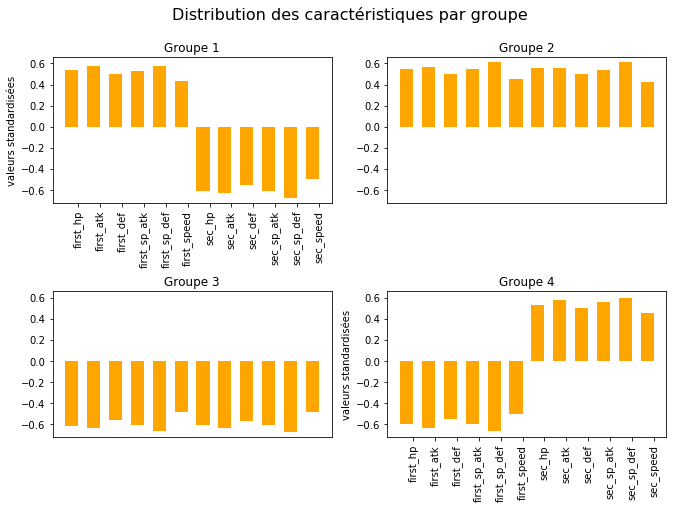

In [28]:
graph_cluster(4, cluster_mean, "Distribution des caractéristiques par groupe", "valeurs standardisées")

À l'aide de la méthode des k-moyennes, nous obtenons quatre groupes distincts représentant des types de combats. Les groupes 1 et 4 contiennent des combats où la distribution des caractéristiques des Pokémon semble être avantageuse pour l'un des deux. En effet, le groupe 1 réunit des combats où le premier Pokemon possède des caractéristiques largement supérieures à celles du second. La situation est inverse dans le groupe 4 où le second Pokémon possède des caractéristiques dominant celles de son adversaire. Pour ce qui est des groupes 2 et 3, ceux-ci contiennent des combats aux résultats plus incertains. Le groupe 2 réunit des combats où les adversaires semblent être tous les deux très forts tandis que le groupe 3 contient des combats ou les adversaires sont tous les plutôt faibles.

In [21]:
# Comparaison des groupes aux résultats des combats
comp = pd.concat([train_numeric["cluster"].reset_index(drop = True),
                  pd.Series(train_y, name = "winner_is_1")], axis = 1)
pd.DataFrame(np.round(pd.crosstab(comp.cluster, comp.winner_is_1, normalize = "index").values, 2),
             columns = ["Pokémon 1 : Défaite", "Pokémon 1 : Victoire"],
             index = ["Groupe 1", "Groupe 2", "Groupe 3", "Groupe 4"])

,Pokémon 1 : Défaite,Pokémon 1 : Victoire
Groupe 1,0.26,0.74
Groupe 2,0.52,0.48
Groupe 3,0.53,0.47
Groupe 4,0.80,0.20


En comparant les résultats de ces regroupements aux résultats des combats, nous constatons sans surprise que les combats provenant du groupe 1 sont gagnés à 74% par le premier combattant. À l'inverse, dans les combats contenus dans le groupe 4, le second Pokémon sort vainqueur 80% du temps. Du côté des combats des groupes 2 et 3, les victoires sont uniformément distribuées entre les combattants.

### 4. Analyse prédictive

Cette section présente l'estimation et l'évaluation d'un modèle prédictif permettant de déterminer le vainqueur dans un affrontement entre deux Pokémon.

Le modèle prédictif estimé est un modèle de forêt aléatoire de classification (en anglais, *random forest*). Ce modèle est un modèle d'ensembles puisqu'il effectue l'agrégation des résultats provenant de diffèrents modèles prédictifs afin d'obtenir des prédictions plus robustes. Dans le cas du modèle de forêt aléatoire appliqué à un problème de classification, les modèles agrégés sont des arbres de classification.

Un arbre de classification est un modèle de prédiction non paramétrique cherchant à réunir des observations dans des noeuds sur la base de leur similitude dans leur variable dépendante. Ces noeuds sont obtenus à la suite d'une série de divisions binaires faites sur l'échantillon. L'arbre commence d'abord avec l'ensemble des observations composant l'échantillon; cet ensemble est appelé le noeud racine. Pour effectuer sa première division, l'algorithme produisant l'arbre de classification cherche parmi l'ensemble des valeurs prises par chacune des variables explicatives celle permettant de diviser les observations de façon à minimiser une mesure quelconque. Lorsque cette valeur est identifiée, elle devient un critère permettant de diviser le premier noeud en deux nouveaux noeuds. Si la valeur choisie est tirée d'une variable continue, la règle de division fait en sorte que les observations possédant une valeur inférieure à la valeur sélectionnée se retrouvent dans le premier noeud alors que celles possédant une valeur supérieure se retrouvent dans le second. Si la division est faite sur une variable binaire, les observations ayant pour cette variable la première valeur se retrouvent dans le premier noeud tandis que celles ayant la seconde valeur se retrouvent dans le second noeud. Une fois ces nouveaux noeuds créés, ceux-ci sont soumis au même processus de division et ainsi de suite.

Il a été mentionné que les divisions sont faites de façon à minimiser une mesure quelconque. Cette mesure est l'impureté des nouveaux noeuds produits. L'impureté est une mesure de la dissemblance des observations réunies dans un noeud. Dans le cas de notre travail, nous entraînons un modèle forêt aléatoire reposant sur des arbres effectuant de la classification, c'est pourquoi la mesure d'impureté utilisée est l'entropie. L'entropie est une mesure de désorganisation ou d'incertitude d'un système. Elle mesure à quel point chacun des noeuds produits lors d'une division est composé d'un mélange uniforme des classes à prédire. Plus la distribution des classes est uniforme dans le noeud, plus l'entropie y est élevée. À l'inverse, plus une classe est sureprésentée par rapport à une autre, plus l'entropie y est faible. Suivant cette logique, l'algorithme cherche à créer des noeuds séparant le mieux possible les classes.

L'algorithme produisant un arbre de classification effectue des divisions sur les noeuds jusqu'à ce qu'une règle d'arrêt soient remplie. Ces règles d'arrêt sont des hyperparamètres du modèle et doivent être sélectionnées afin construire les arbres qui composent le modèle de forêt aléatoire. Ces hyperparamètres déterminent des contraintes sur la dimension des arbres de façon à éviter le surapprentissage, c'est-à-dire l'incapacité du modèle à se généraliser à de nouvelles données. Dans le cas des arbres de classification, les hyperparamètres à sélectionner sont la profondeur maximale de l'arbre en terme de noeuds, le nombre minimal d'observations devant se retrouver dans un noeud terminal, c'est-à-dire un noeud à partir duquel sera fait une prédiction, et le nombre minimal d'observations devant se retrouver dans un noeud pour que celui-ci soit éligible à une nouvelle division.

Les hyperparamètres sont sélectionnés par validation croisée. La validation croisée consiste à diviser le groupe d'entraînement en une série de sous-groupes. Ces sous-groupes sont utilisés pour estimer le modèle en omettant un des groupes de l'estimation. Ce groupe omis est ensuite utilisé pour effectuer des prédictions et évaluer la performance du modèle. Ce processus est effectué de façon à ce que chacun des groupes serve de groupe test. Cette procédure est ensuite effectuée pour chaque ensemble de paramètres candidats possibles. Les paramètres ayant générés la meilleure performance moyenne à travers les sous-groupes sont ceux conservés pour estimer le modèle sur l'ensemble des données.

Lorsque la construction d'un arbre est terminée, de nouvelles observations peuvent lui être fournies afin d'effectuer des prédictions pour celles-ci. Un arbre de décision représentant essentiellement une série de régles "si/alors", l'observation n'a qu'à être classée dans un noeud terminal en suivant chacune des règles qui s'applique à elle. La prédiction est effectuée à partir des données utilisées pour entraîner l'arbre. En fait, la prédiction faite pour la nouvelle observation est la classe représentant le mode de la variable dépendante parmi les observations se trouvant dans le noeud terminal.

Un modèle de forêt aléatoire estime plusieurs arbres de classification pour ensuite agréger leur prédiction. Pour ce faire, il utilise la méthode *bootstrap*. Cette méthode consiste à sélectionner plusieurs nouveaux échantillons à partir de l'échantillon initial. Chacun de ces nouveaux échantillons est ensuite utilisé pour estimer un arbre de classification différent. Toutefois, simplement estimer une série d'arbres de classification sur des échantillons *bootstrap* risquerait de générer une série d'arbres très similaires. Le modèle de forêt aléatoire impose donc une restriction supplémentaire en ne permettant qu'à une partie des variables explicatives disponibles d'être candidates pour effectuer les divisions. Ces variables sont sélectionnées de façon aléatoire à chaque nouvelle division pour chacun des arbres entraînés.

Lorsqu'une nouvelle observation est fournie au modèle de forêt aléatoire, celui-ci effectue une série de prédictions à l'aide de l'ensemble des arbres de classification qui le composent. Chacune de ces prédictions étant une classe, le modèle de forêt aléatoire utilise la classe ayant été prédite le plus souvent par les arbres de classification comme prédiction.

Pour évaluer la performance prédictive de notre modèle, la précision (traduction de *accuracy*, à distinguer de *precision*) sera utilisée. La précision représente la proportion des prédictions qui ont la même valeur que celle attendue. Une limite de cette mesure de performance est de ne pas être adaptée à la prédiction d'évènements rares, mais cette situation ne s'applique pas ici puisque nos deux classes (défaite/victoire du combattant un) sont réparties presque uniformément parmi les observations.

Dans le code qui suit, le modèle de forêt aléatoire est appelé à l'aide de la classe `RandomForestClassifier`. La validation croisée permettant de sélectionner le meilleur ensemble d'hyperparamètres est définie à l'aide de la classe `GridSearchCV` et est estimée grâce à la méthode `fit`. Ces deux classes proviennent du module `SciKit-Learn`.

In [181]:
%%time

# Définition de l'estimateur random forest
rforest = RandomForestClassifier(n_estimators = 50,
                                  criterion = "entropy",
                                  random_state = 222,
                                  max_features = 0.35,
                                  n_jobs = 3)

# Définition des hyperparamètres candidats pour la validation croisée
params = {"max_depth" : np.arange(1, 20, 1),
          "min_samples_leaf" : np.arange(1, 20, 1),
          "min_samples_split" : np.arange(2, 20, 1)}

# Paramétrisation de la validation croisée
cv_rforest = GridSearchCV(rforest, param_grid = params,
                          scoring = "accuracy")

# Sélection des hyperparamètres par validation croisée
cv_rforest.fit(train_prep, train_y)

CPU times: user 10h 14min 23s, sys: 15min 12s, total: 10h 29min 36s
Wall time: 5h 18min 42s


In [182]:
# Obtention des paramètres sélectionnés
cv_rforest.best_params_

{'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 3}

Le modèle dont la performance est maximisée dans le cadre de notre analyse est celui dont les arbres de classification composant la forêt aléatoire possèdent une profondeur maximale de dix-huit noeuds. Les arbres peuvent également contenir minimalement une seule observation dans un noeud terminal. Enfin, la présence d'au moins trois observations dans un noeud est requise pour que celui-ci soit candidat à une nouvelle division.

Il est possible d'évaluer la performance naïve de ce modèle en calculant la précision sur l'ensemble de notre groupe d'entraînement. Cette mesure est obtenue à l'aide de la fonction `accuracy_score` du module `SciKit-Learn`.

In [39]:
train_y_pred = cv_rforest.best_estimator_.predict(train_prep)
rf_accuracy = accuracy_score(train_y, train_y_pred)

In [40]:
print("Naive accuracy : ", rf_accuracy)

Naive accuracy :  0.9954


Dans le cas de notre modèle, la mesure de performance naïve de celui-ci est de 99,54%. Cette mesure est toutefois optimiste puisqu'elle est estimée sur une partie des observations utilisées pour entraîner le modèle prédictif.

La performance intra-échantillon de ce modèle peut également être mesurée à l'aide de la validation croisée enboîtée. Cette technique permet d'estimer le modèle sur une partie des données et de valider sa performance sur le reste de celles-ci. La validation croisée emboîtée est effectuée à l'aide de la classe `cross_val_score` du module `SciKit-Lear` à laquelle nous fournissons comme estimateur le modèle obtenu par validation croisée calculé à l'aide de `GridSearchCV`.

In [41]:
%%time

rforest_nested = cross_val_score(cv_rforest, train_prep, train_y,
                                 cv = 10, scoring = "accuracy")

CPU times: user 3d 20h 22min 59s, sys: 2h 16min 54s, total: 3d 22h 39min 54s
Wall time: 2d 2h 44min 14s


In [42]:
print("Nested CV Accuracy :", np.round(np.mean(rforest_nested), 5))

Nested CV Accuracy : 0.95091


Comme nous devions nous y attendre, la performance du modèle estimée par validation croisée emboîtée est plus conservatrice. À l'aide de cette méthode, nous obtenons une précision de 95,09%. Cela signifie que le gagnant prédit par notre modèle sort effectivement vainqueur de l'affrontement 95% du temps.

Il est à noter toutefois que l'estimation de la performance par validation croisée emboîtée peut être passablement longue. Ce temps de calcul peut également être augmenté lors de l'estimation de modèles non paramétriques, ce qui est le cas avec le modèle de forêt aléatoire. En l'occurence, le calcul de la performance par cette méthode a pris un peu plus de deux jours à se faire.

Nous nous intéressons ensuite aux variables explicatives ayant un impact sur la formation des arbres de classification contenus dans notre modèle de forêt aléatoire. Cet impact est mesuré par l'importance de chaque variable, c'est-à-dire la contribution relative de chacune d'elles dans la réduction de l'impureté (dans notre cas, mesurée par l'entropie) lors de l'estimation de l'ensemble des arbres constituant la forêt aléatoire.

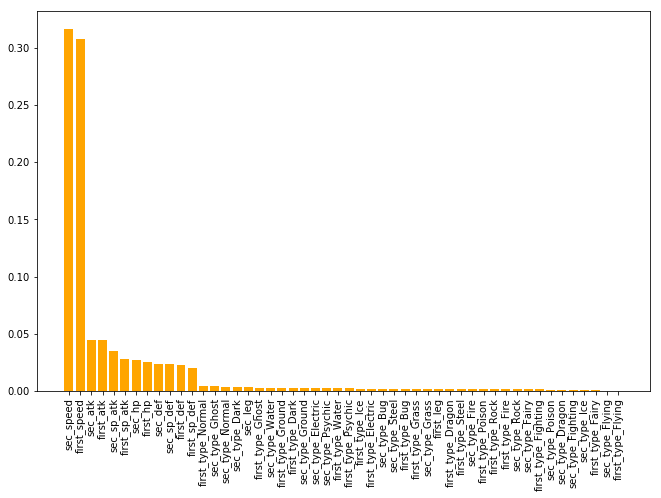

In [193]:
# Extraction de l'information sur l'importance
importance = pd.DataFrame(np.array([cv_rforest.best_estimator_.feature_importances_,
                           train_prep.columns]).T,
                          columns = ["import", "variable"])
importance = importance.sort_values(["import"], ascending = False)

# Création de la figure permettant de représenter l'importance des variables explicatives
fig = plt.figure(figsize = (11, 7))
fig.suptitle("Importance relative des caractéristiques des Pokemon ", fontsize = 16)
ax = fig.add_subplot(1, 1, 1)
ax.bar(x_axe, importance["import"], color = "orange")
ax.set_xticks(x_axe)
ax.set_xticklabels(importance["variable"], rotation = 90)
plt.show()

Il est possible de constater qu'un peu de plus de 60% de la réduction de l'impureté dans notre modèle de forêt aléatoire est due à deux variables, à savoir la vitesse de chacun des adversaires impliqués dans le combat. En ajoutant les deux variables suivantes, la force d'attaque de chacun des Pokémon, c'est environ 75% de la réduction de l'impureté qui est expliquée. Ainsi, ces quatre variables jouent un rôle déterminant dans la construction des arbres de classification.

Il est à noter que le modèle de forêt aléatoire possède comme avantage de permettre facilement la sélection de variables explicatives pertinentes. Dans notre cas, il semble évident que les variables captant le type de chacun des Pokémon ont un apport négligeable dans le modèle. Une façon de rendre l'estimation de celui-ci plus rapide pourrait donc être de simplement ignorer ces variables lors de la procédure.

Les mesures de performance naïve et obtenue par validation croisée emboîtée sont importantes dans la sélection de notre modèle, mais elles demeurent toujours à risque d'un biais optimiste. La meilleure façon de valider la performance d'un modèle est de mesurer la qualité de ses prédictions sur des données auxquelles il n'a jamais été exposées. Nous pouvons effectuer cet exercice à l'aide du groupe test que nous avons créé en début d'analyse et que nous n'avons pas touché depuis. 

In [227]:
print("Taille du groupe test = ", test.shape, sep = "")

Taille du groupe test = (15000, 16)


Tel que mentionné précédemment, le groupe test contient 15 000 observations. C'est sur ces observations que la performance hors échantillon de notre modèle prédictif sera mesurée. Tout comme le groupe d'entraînement, nous nous assurons que le groupe test ne contient aucune valeur manquante.

In [196]:
test.describe(include = "all")

,first_type,first_hp,first_atk,first_def,first_sp_atk,first_sp_def,first_speed,first_leg,sec_type,sec_hp,sec_atk,sec_def,sec_sp_atk,sec_sp_def,sec_speed,sec_leg,winner_is_1
count,15000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000,15000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.00000,15000,15000.000000
unique,18,NaN,NaN,NaN,NaN,NaN,NaN,2,18,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,Water,NaN,NaN,NaN,NaN,NaN,NaN,0,Water,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
freq,2029,NaN,NaN,NaN,NaN,NaN,NaN,13756,2106,NaN,NaN,NaN,NaN,NaN,NaN,13797,NaN
mean,NaN,69.267133,78.964867,74.174400,73.061600,72.068333,68.300067,NaN,NaN,69.068533,78.961267,74.301400,72.356400,72.066733,67.97860,NaN,0.470733
std,NaN,25.429819,32.799151,31.637921,32.919654,27.906914,29.530236,NaN,NaN,25.245431,32.396977,31.731817,32.376179,28.385701,29.30995,NaN,0.499159
min,NaN,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,NaN,NaN,1.000000,5.000000,5.000000,10.000000,20.000000,5.00000,NaN,0.000000
25%,NaN,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000,NaN,NaN,50.000000,55.000000,50.000000,50.000000,50.000000,45.00000,NaN,0.000000
50%,NaN,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,NaN,NaN,65.000000,75.000000,70.000000,65.000000,70.000000,65.00000,NaN,0.000000
75%,NaN,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,NaN,NaN,80.000000,100.000000,90.000000,95.000000,90.000000,90.00000,NaN,1.000000


Nous vérifions également que notre seule variable carégorique ne possède aucune anomalie.

In [197]:
test["first_type"].value_counts()

Water       2029
Normal      1833
Bug         1309
Grass       1289
Psychic     1144
Fire        1011
Rock         869
Electric     815
Dragon       597
Ghost        587
Ground       564
Poison       551
Dark         531
Steel        520
Fighting     511
Ice          454
Fairy        313
Flying        73
Name: first_type, dtype: int64

Puisque les données contenues dans notre groupe test ne semblent pas contenir de valeur manquante, nous pouvons les préparer pour l'algorithme. Cette préparation devant être la même que celle des données d'entraînement, nous utilisons les mêmes fonctions que nous avons créées pour dichotomiser les variables catégoriques et standardisiser les variables continues.

In [220]:
# Construction de l'outcome
test_y = test["winner_is_1"].values
test = test.drop("winner_is_1", axis = 1)

# Dichotomisation des variables catégoriques
test_cat = tran_dummy(test, ["first_type", "sec_type"], ["first_leg", "sec_leg"])

In [221]:
# Standardisation des variables numériques continues
test_numeric = tran_cont(test,
                          ["first_type",
                           "sec_type",
                           "first_leg",
                           "sec_leg"])

# Reconstruction du nouveau dataframe
test_prep = pd.concat([test_cat, test_numeric], axis = 1, join_axes = [test_cat.index])

Contrairement à lorsque nous avons standardisé les variables continues du groupe d'entraînement, la fonction `call_scaler` n'a pas été appelée pour la standardisation des variables continues du groupe test. C'est le cas puisque cette fonction sert à initialiser la classe permettant la standardisation des données. Dans le cas du groupe test, nous voulons récupérer les valeurs utilisées pour standardiser les observations du groupe d'entraînement plutôt que d'en calculer de nouvelles pour le groupe test. C'est pourquoi la classe n'est pas réinitialisée.

Les prédictions pour le groupe test sont ensuite obtenues et comparées aux valeurs attendues. Ceci nous permet d'obtenir la précision hors échantillon, la véritable mesure de performance de notre modèle.

In [228]:
test_y_pred = cv_rforest.best_estimator_.predict(test_prep)
rf_accuracy_test = accuracy_score(test_y, test_y_pred)

In [229]:
print("Out of sample accuracy :", np.round(np.mean(rf_accuracy_test), 5))

Out of sample accuracy : 0.9492


Notre précision hors échantillon est de 94,92%, ce qui signifie que près de 95% de nos prédictions concernant le vainqueur d'un combat de Pokémon s'avèrent exactes.

Il est intéressant de constater que même si la performance naïve calculée était effectivement optimiste sur la qualité de notre modèle prédictif, celle obtenue à l'aide de la validation croisée emboîtée était assez près de la performance obtenue hors échantillon. Ceci suggère que cette méthode est bien appropriée pour mesurer la performance prédictive la capacité d'un modèle à se généraliser à de nouvelles données. 

### 5. Conclusion

Dans ce travail nous avons tenté de comprendre la dynamique des combats de Pokémon. Pour ce faire, nous avons utilisé des données obtenus sur le site Kaggle. Ces données introduites dans une base de données SQLite à laquelle nous avons pu ensuite faire une requête pour obtenir de façon optimale les données dont nous avions besoin. Les données ont ensuite été partitionnées puis préparées pour les analyses exploratoire et prédictive.

Dans notre analyse exploratoire, nous avons découvert que nos combats peuvent être rassemblés en 4 grands groupes, soient deux groupes où l'un des adversaires est nettement plus fort que l'autre et deux autres groupes où les adversaires sont soient tous deux très forts, soient tous deux très faibles. Pour ce qui est de notre analyse prédictive, nous avons construit un modèle prédictif qui permet de déterminer le vainqueur de ces combats. Notre modèle possède une performance hors échantillon d'environ 95%. 

Notre analyse possède quelques limites et extensions possibles. D'abord, notre analyse exploratoire a porté uniquement sur les variables continues, ce qui a pu laisser de côté une partie de l'information contenue dans les données. Nous avons toutefois vu à l'aide de notre modèle prédictif que les variables demeurées inutilisées dans notre analyse exploratoire semblent avoir une importance secondaire dans l'issue des combats.

Du côté de notre modèle prédictif, le nombre d'arbres utilisés dans notre forêt aléatoire est relativement faible (50), notamment puisque celui-ci est très long à entraîner. Ce temps d'entraînement pourrait toutefois être réduit en retirant les variables catégoriques puisque, comme nous l'avons vu, celles-ci semblent permettre une diminution faible de l'impureté dans les arbres de classification. Enfin, il serait intéressant de comparer nos résultats à ceux obtenus à l'aide d'un modèle prédictif paramétrique, donc imposant une structure plus grande sur la relation entre les variables. Il nous permettrait notamment d'avoir une mesure de performance comparative pour notre modèle et de voir si un modèle plus simple parviendrait à une performance similaire.